# Reddit Churn Analysis
* Instructor: `Shahbaz Chaudhary`
* Team: MSCA Data Scientists 
  * `Zoila Joyo Calderon`
  * `Lauren Sample`
  * `Ruobing Xue`
  * `Elly Yang`

## Load Data

In [1]:
import numpy as np
import pandas as pd
DF = pd.read_feather('RC_2012_year_cohort.feather')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234225454 entries, 0 to 234225453
Data columns (total 3 columns):
 #   Column       Dtype   
---  ------       -----   
 0   created_utc  int64   
 1   author       category
 2   subreddit    category
dtypes: category(2), int64(1)
memory usage: 3.6 GB


In [2]:
DF.head()

,created_utc,author,subreddit
0,1325376000,irwinator,AskReddit
1,1325376000,reed311,politics
2,1325376000,sagapo3851,gaming
3,1325376000,filthgrinder,politics
4,1325376001,BitterDivorcedDad,WTF


## Find the top 10 subreddits

In [3]:
top10 = DF.groupby('subreddit').size().sort_values(ascending=False)[:10].index.tolist()
top10

['AskReddit',
 'funny',
 'pics',
 'gaming',
 'WTF',
 'politics',
 'atheism',
 'leagueoflegends',
 'IAmA',
 'trees']

## Zoom in on one subreddit

In [4]:
# using subreddit 'AskReddit' as an example
i = 'AskReddit'
df = DF.loc[DF['subreddit']==i, ['created_utc', 'author']]
df.head()

,created_utc,author
0,1325376000,irwinator
30,1325376005,AddictivePotential
40,1325376006,Solumin
76,1325376012,AliasSigma
79,1325376013,[deleted]


## Find the date of first interaction for that subreddit

In [5]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s').dt.date
day0 = df.groupby('author').agg({'created_utc': np.min}).sort_values(by='created_utc')
day0.rename(columns={'created_utc': 'day0'}, inplace=True)
day0.head()

,day0
author,
penisapologies,2012-01-01
xDeda,2012-01-01
SimplyBilly,2012-01-01
Simpleton216,2012-01-01
SimpleSimian,2012-01-01


## Combine the initial dataframe with comment timestamps

In [6]:
df_merged = pd.merge(df, day0, left_on='author', right_index=True)
df_merged['nDays'] = (df_merged['created_utc'] - df_merged['day0']).dt.days
df_merged.drop(['created_utc', 'day0'], axis=1, inplace=True)
df_merged.drop_duplicates(inplace=True)
df_merged.head()

,author,nDays
0,irwinator,0
417044,irwinator,1
3124070,irwinator,6
5128406,irwinator,9
7285615,irwinator,13


## Pivot the dataframe with authors on one axis and days they commented on another

In [7]:
df_merged['commented'] = 1
df_pivot = df_merged.pivot(index='nDays', columns='author', values='commented')
df_pivot.head()

author,irwinator,AddictivePotential,Solumin,AliasSigma,[deleted],hecticengine,homer1969,rco8786,kagutsuchi,elliottblackwood,...,eggmaker,a_cure_for_death,snazzius,alliteratorsalmanac,sutenlikedat,MemeWatcher,Vogad,koopa-poopa,BricksThrown,pearson32
nDays,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sum the number of commenters for each day

In [8]:
daySum = df_pivot.sum(axis=1)
daySum.head()

nDays
0    1125887.0
1     118319.0
2      79764.0
3      68751.0
4      63902.0
dtype: float64

## Calculate the % of authors who returned after their first comment

In [9]:
dayPer = daySum/daySum[0]
dayPer.head()

nDays
0    1.000000
1    0.105090
2    0.070845
3    0.061064
4    0.056757
dtype: float64

## Plot retention rate

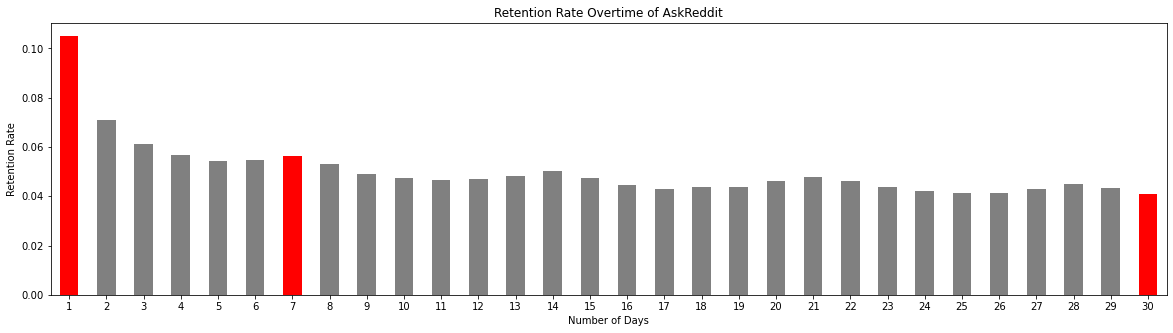

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
ax = dayPer[1:31].plot(kind='bar', color='grey', rot='0')
plt.xlabel('Number of Days')
plt.ylabel('Retention Rate')
for j in [1, 7, 30]: ax.patches[j-1].set_facecolor('red')
plt.title('Retention Rate Overtime of ' + i);

## Put everything together
* `Day 1` experiences the greatest drop of retention rate with less than 12% left depending on the subreddit
* Retention rate stablizes between `Day 7` and `Day 30` with cyclic weekly patterns

In [11]:
def getSub(nameSub):
    df = DF.loc[DF['subreddit'] == nameSub, ['created_utc', 'author']]
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s').dt.date
    day0 = df.groupby('author').agg({'created_utc': np.min}).sort_values(by='created_utc')
    day0.rename(columns={'created_utc': 'day0'}, inplace=True)
    
    df_merged = pd.merge(df, day0, left_on='author', right_index=True)
    df_merged['nDays'] = (df_merged['created_utc'] - df_merged['day0']).dt.days
    df_merged.drop(['created_utc', 'day0'], axis=1, inplace =True)
    df_merged.drop_duplicates(inplace=True)

    df_merged['commented'] = 1
    df_pivot = df_merged.pivot(index='nDays', columns='author', values='commented')
    
    daySum = df_pivot.sum(axis=1)
    dayPer = daySum/daySum[0]
    
    plt.figure(figsize=(20,5))
    ax = dayPer[1:31].plot(kind='bar', color='grey', rot='0')
    plt.xlabel('Number of Days')
    plt.ylabel('Retention Rate')
    for j in [1, 7, 30]: ax.patches[j-1].set_facecolor('red')
    plt.title('Retention Rate Overtime of ' + i);

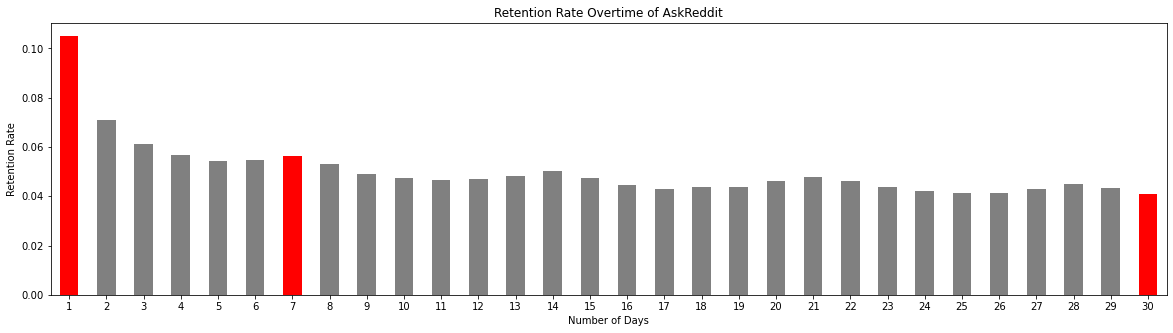

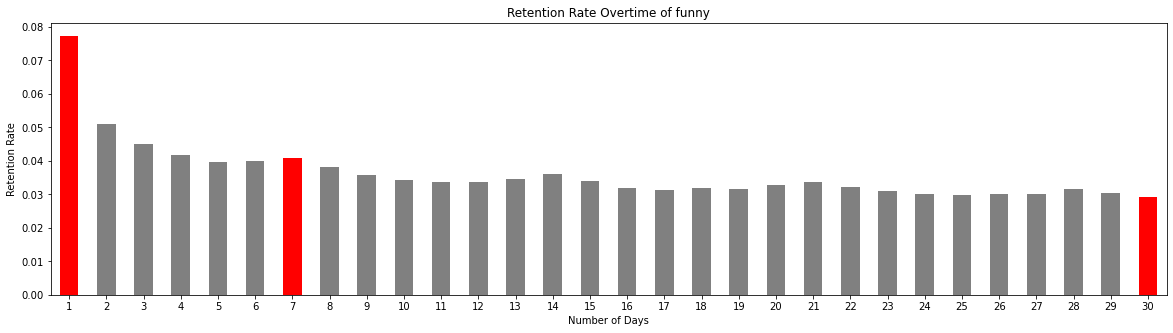

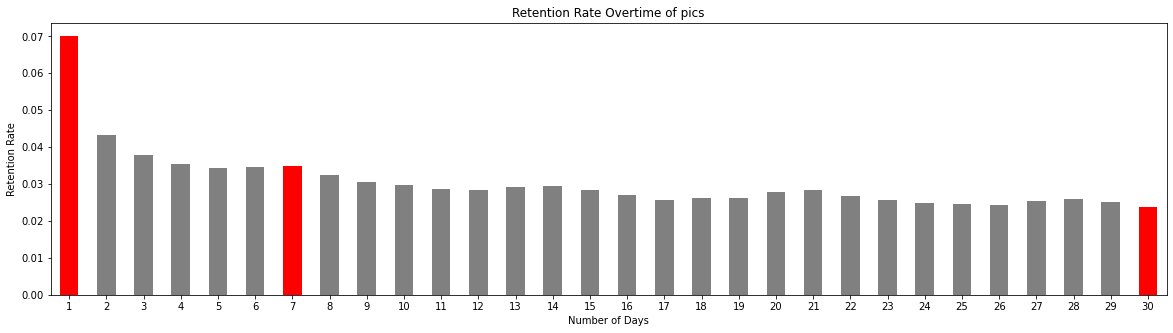

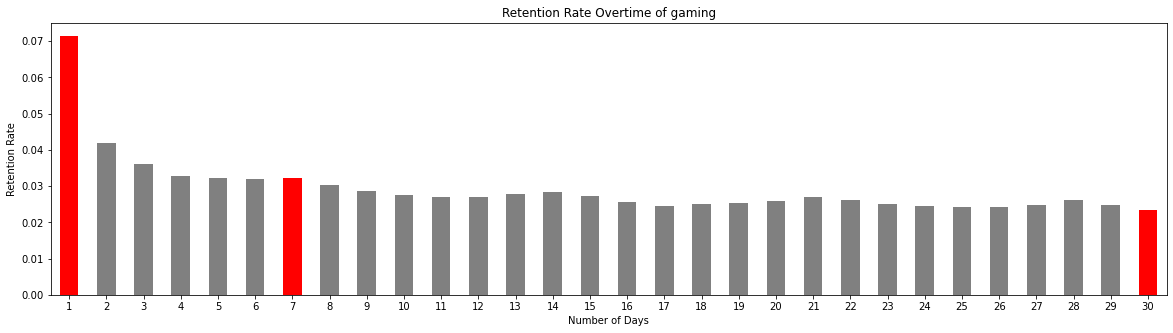

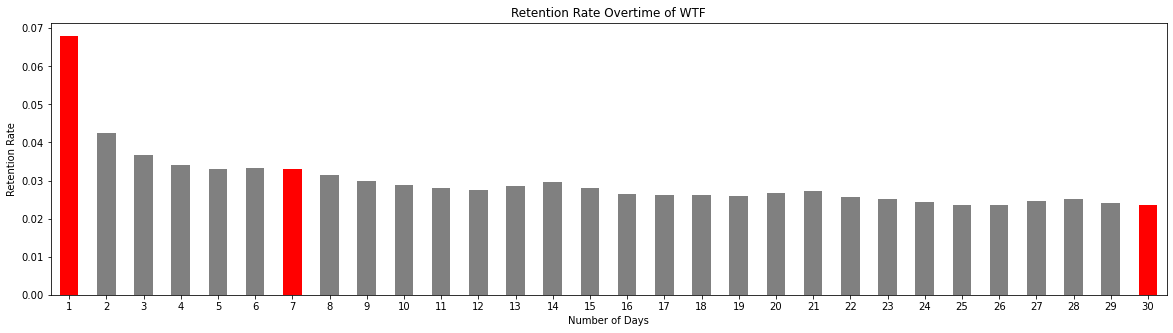

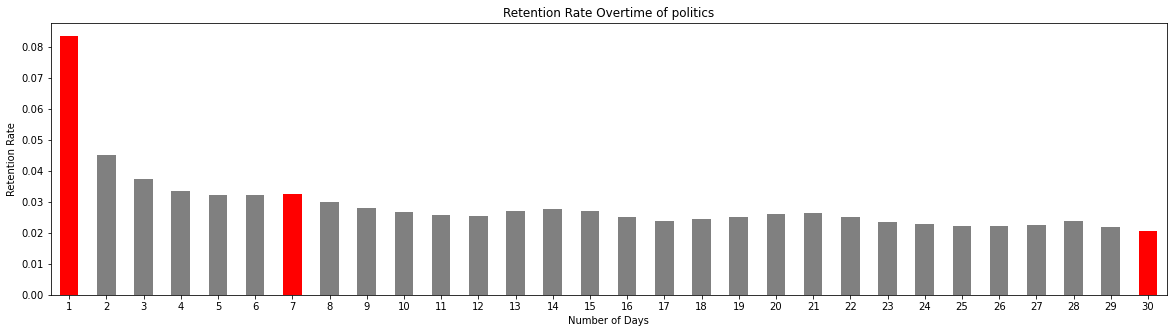

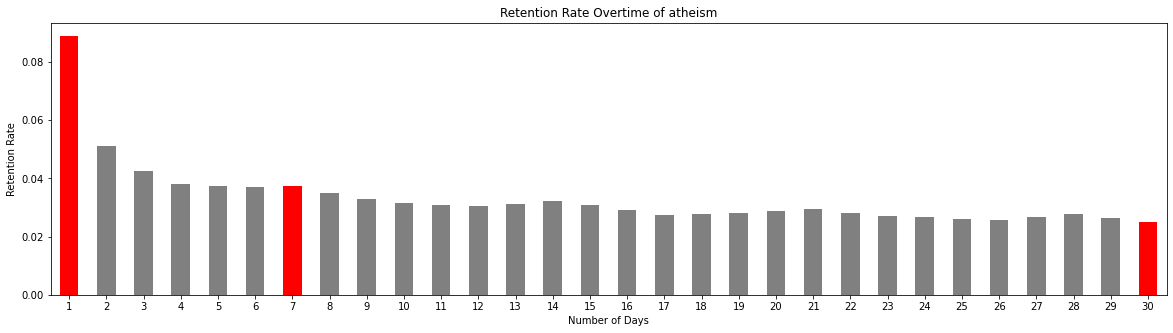

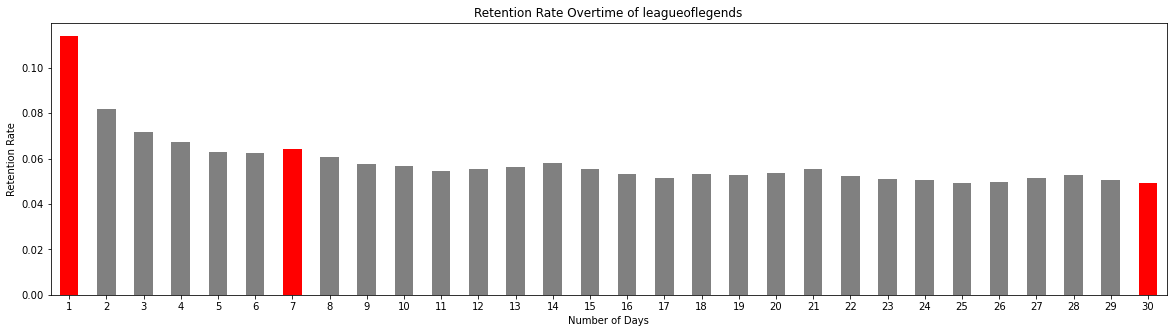

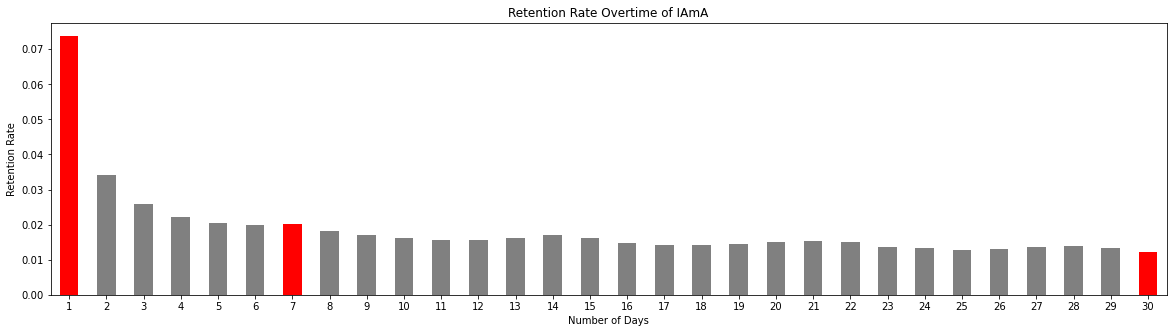

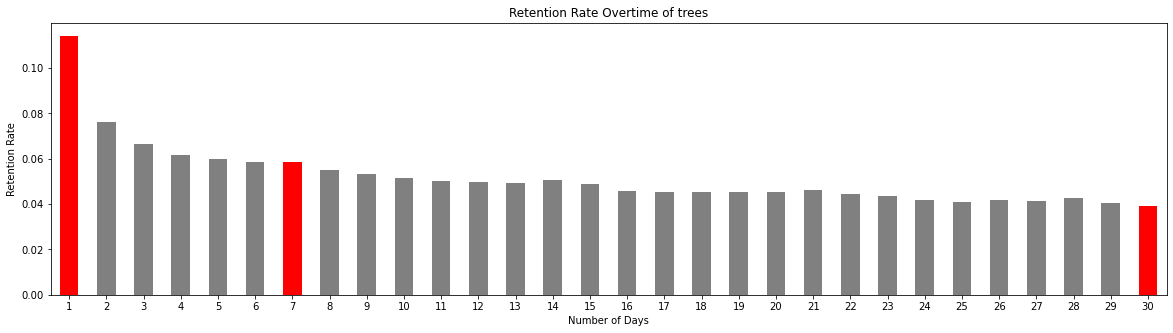

In [12]:
for i in top10: getSub(i)